In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image
%matplotlib inline
from skimage import img_as_ubyte
from skimage import restoration, img_as_ubyte
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import skeletonize

13


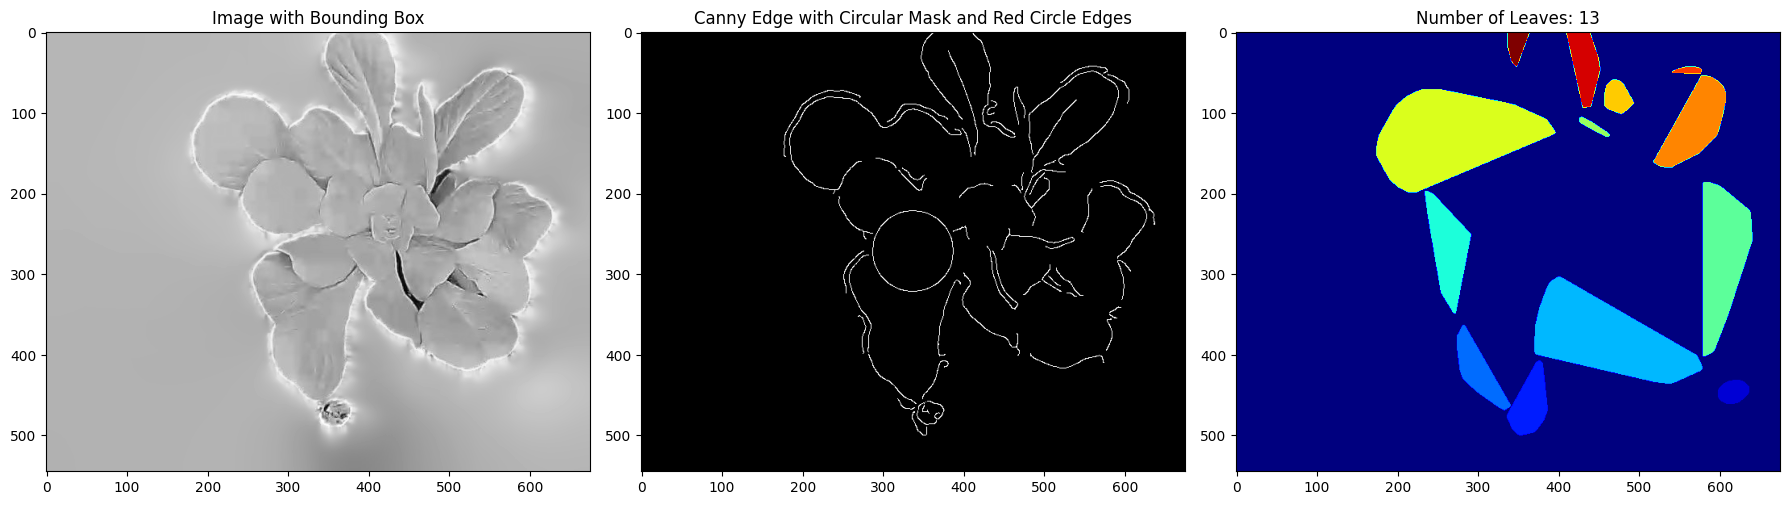

In [70]:
# Load your image (replace 'path/to/your/image.jpg' with the actual path)
image_path = '/content/drive/MyDrive/Background_removed_lettuce/background_removed_lettuce/01/plant1_01_06_2023_15_balcony.jpg'
image1 = cv2.imread(image_path,cv2.IMREAD_COLOR)
image_rgb = image1[:, :, :: -1]
image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

#Step 1: Image Enhancement using Deconvolution
psf = np.ones((5, 5)) / 25  # Example point spread function
deconvolved = cv2.filter2D(image, -1, psf)
#Step 2: Bounding Box
contours, _ = cv2.findContours(img_as_ubyte(deconvolved), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])
# Step 3: Centroid Computation of Bounding Box
centroid_x = x + w // 2
centroid_y = y + h // 2
# Step 4: Circle at the center of bounding box and exclude that region
radius = 50  # Adjust the radius as needed
mask = np.zeros_like(deconvolved)
cv2.circle(mask, (centroid_x, centroid_y), radius, 255, -1)
deconvolved[mask == 255] = 0
# Step 5: Canny Edge Detection
edge_canny = canny(deconvolved, sigma=2)
# Step 6: Thresholding
_, binary_image = cv2.threshold(deconvolved, 200, 255, cv2.THRESH_BINARY)
# Step 7: Morphological Operations (Erosion and Dilation)
kernel = np.ones((5, 5), np.uint8)
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Step 8: Contour Detection
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Step 9: Filtering Contours based on Size
filtered_contours = [cnt for cnt in contours if 100 < cv2.contourArea(cnt) < 5000]
# Step 10: Convex Hull
convex_hulls = [cv2.convexHull(cnt) for cnt in filtered_contours]
# Step 11: Leaf Feature Extraction
leaf_features = [{'area': cv2.contourArea(cnt), 'perimeter': cv2.arcLength(cnt, True)} for cnt in convex_hulls]
# Step 12: Leaf Labeling
labels = np.zeros_like(binary_image)
for i, cnt in enumerate(convex_hulls):
    cv2.drawContours(labels, [cnt], -1, i + 1, thickness=cv2.FILLED)
# Step 13: Counting Leaves
num_leaves = len(leaf_features)
print(num_leaves)
# Step 19: Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Image with Bounding Box')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny, cmap='gray')
plt.title('Canny Edge with Circular Mask and Red Circle Edges')

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

#Refined Approach - Centroid Found

16


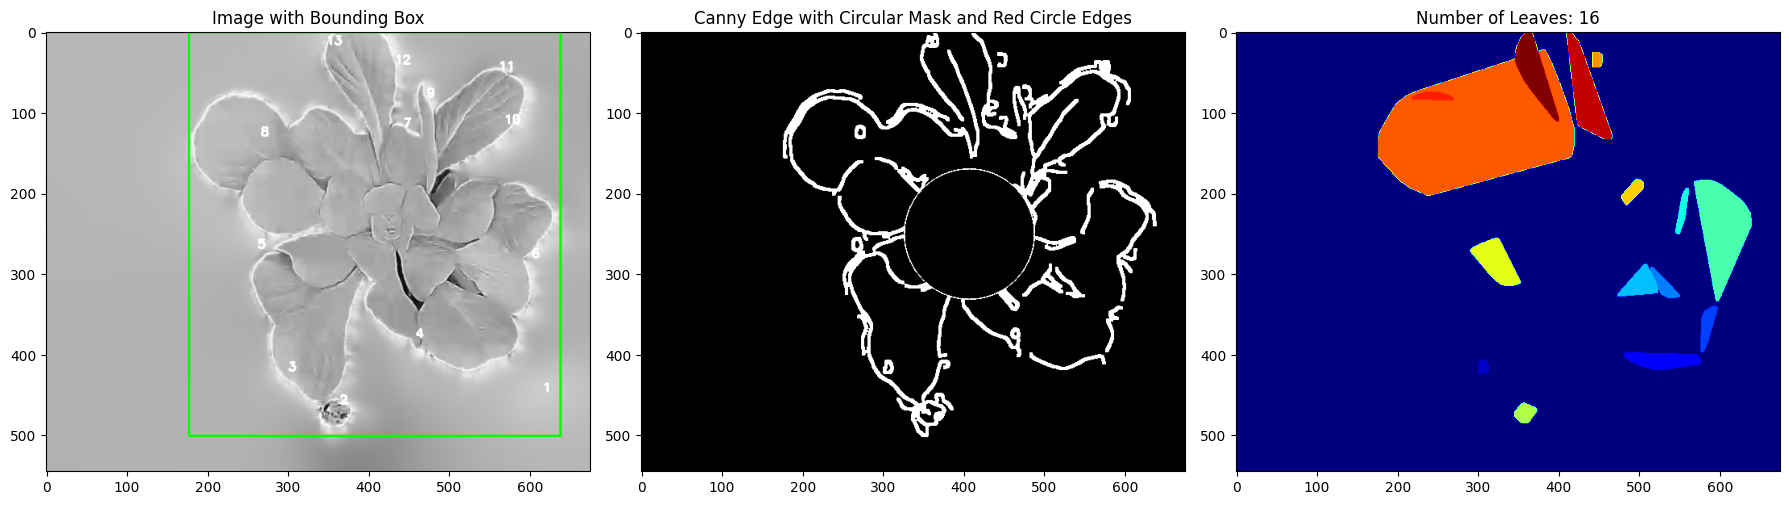

In [77]:
# Step 1: Image Enhancement using Deconvolution
psf = np.ones((5, 5)) / 25  # Example point spread function
deconvolved = cv2.filter2D(image, -1, psf)

# Step 2: Canny Edge Detection
edge_canny = canny(deconvolved, sigma=2)

# Step 3: Manually tweak edges using morphological operations
kernel_dilate = np.ones((5, 5), np.uint8)
kernel_erode = np.ones((2, 2), np.uint8)

edge_canny_dilated = cv2.dilate(img_as_ubyte(edge_canny), kernel_dilate, iterations=1)
edge_canny_tweaked = cv2.erode(edge_canny_dilated, kernel_erode, iterations=1)

# Step 3: Find contours in the Canny edge image
contours, _ = cv2.findContours(img_as_ubyte(edge_canny), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Initialize variables for bounding box
min_x, min_y, max_x, max_y = float('inf'), float('inf'), 0, 0

# Step 6: Iterate through contours to find bounding box coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

# Step 7: Visualize the bounding box on the original image
image_with_bounding_box = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bounding_box, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

# Step 8: Calculate the center of the bounding box
plant_center_x = (min_x + max_x) // 2
plant_center_y = (min_y + max_y) // 2

# Step 9: Create a circular mask around the plant
radius = 80  # Adjust the radius as needed
mask = np.zeros_like(image)
cv2.circle(mask, (plant_center_x, plant_center_y), radius, 255, -1)

##New step
# Step 10: Overlay the circular mask on the Canny edge image with circle edges in red
edge_canny_tweaked_with_circle = edge_canny_tweaked.copy()
cv2.circle(edge_canny_tweaked_with_circle, (plant_center_x, plant_center_y), radius, (255, 0, 0), 2)

# Step 11: Ignore edges inside the circular mask
edge_canny_tweaked_with_circle[mask == 255] = 0

# Step 12: Contour Detection
contours, _ = cv2.findContours(img_as_ubyte(edge_canny_tweaked_with_circle), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Step 13: Filtering Contours based on Size
filtered_contours = [cnt for cnt in contours if 100 < cv2.contourArea(cnt) < 5000]

# Step 14: Convex Hull
convex_hulls = [cv2.convexHull(cnt) for cnt in filtered_contours]

# Step 15: Leaf Feature Extraction
leaf_features = [{'area': cv2.contourArea(cnt), 'perimeter': cv2.arcLength(cnt, True)} for cnt in convex_hulls]

# Step 16: Leaf Labeling
labels = np.zeros_like(img_as_ubyte(edge_canny_tweaked_with_circle))
for i, cnt in enumerate(convex_hulls):
    cv2.drawContours(labels, [cnt], -1, i + 1, thickness=cv2.FILLED)

# Step 17: Counting Leaves
num_leaves = len(leaf_features)
print(num_leaves)

# Step 18: Visualize the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_with_bounding_box, cmap='gray')
plt.title('Image with Bounding Box')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked_with_circle, cmap='gray')
plt.title('Canny Edge with Circular Mask and Red Circle Edges')

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

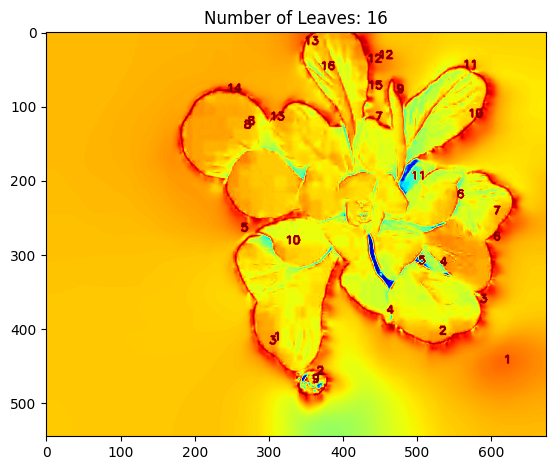

In [78]:
# Step 19: Label the identified leaves on the Convex Hull image
for i, cnt in enumerate(convex_hulls):
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(image, str(i + 1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.imshow(image, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

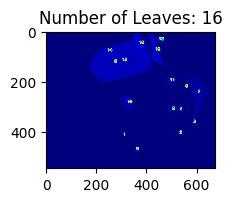

In [79]:
# Step 19: Label the identified leaves on the Convex Hull image
for i, cnt in enumerate(convex_hulls):
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.putText(labels, str(i + 1), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

plt.subplot(1, 3, 3)
plt.imshow(labels, cmap='jet')
plt.title(f'Number of Leaves: {num_leaves}')

plt.tight_layout()
plt.show()

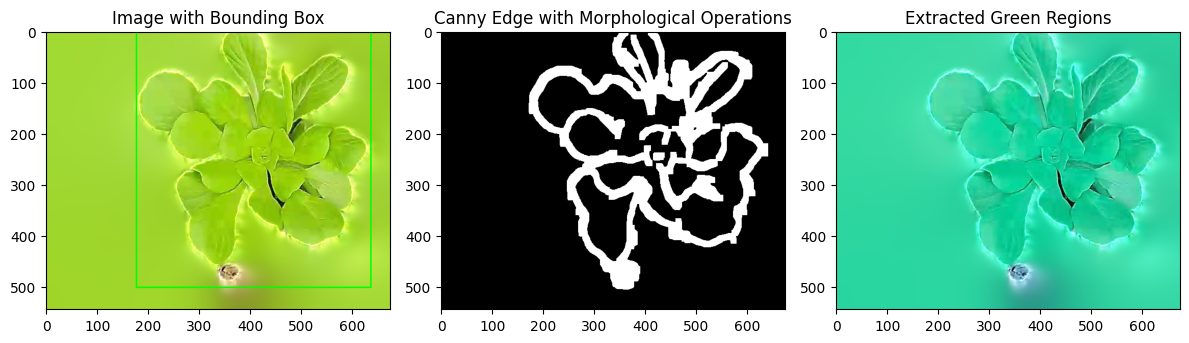

In [23]:
image = cv2.imread('/content/drive/MyDrive/Background_removed_lettuce/background_removed_lettuce/01/plant1_01_06_2023_15_balcony.jpg')
# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the green color
lower_green = np.array([0, 0, 0])  # Adjust these values based on your specific case
upper_green = np.array([80, 255, 255])

# Create a mask to extract the green regions
mask = cv2.inRange(hsv, lower_green, upper_green)

# Apply the mask to the original image
result = cv2.bitwise_and(image, image, mask=mask)

# Convert the result to grayscale
gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# Step 2: Canny Edge Detection
edge_canny = canny(gray_result, sigma=2)

# Step 3: Fine-Tune Morphological Operations
kernel_dilate = np.ones((7, 7), np.uint8)
kernel_erode = np.ones((3, 3), np.uint8)

edge_canny_dilated = cv2.dilate(img_as_ubyte(edge_canny), kernel_dilate, iterations=2)
edge_canny_tweaked = cv2.erode(edge_canny_dilated, kernel_erode, iterations=1)

# Step 4: Find contours in the Canny edge image
contours, _ = cv2.findContours(img_as_ubyte(edge_canny), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Initialize variables for bounding box
min_x, min_y, max_x, max_y = float('inf'), float('inf'), 0, 0

# Step 6: Iterate through contours to find bounding box coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    min_x = min(min_x, x)
    min_y = min(min_y, y)
    max_x = max(max_x, x + w)
    max_y = max(max_y, y + h)

# Step 7: Visualize the bounding box on the original image
image_with_bounding_box = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
cv2.rectangle(image_with_bounding_box, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_with_bounding_box)
plt.title('Image with Bounding Box')

plt.subplot(1, 3, 2)
plt.imshow(edge_canny_tweaked, cmap='gray')
plt.title('Canny Edge with Morphological Operations')

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title('Extracted Green Regions')

plt.tight_layout()
plt.show()